In [1]:
import os
import re
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
mint=pd.read_csv('MINTDEF.csv',index_col=0, header=0)
#All retweets are automatically removed by twint. CHECK
mint=mint[mint.retweet==False]
#All bots are automatically removed by twint
mint.head()

,user_id,username,date,tweet,retweet,hashtags,nlikes,nretweets,language,Company
0,279236166,EJLizama,2021-06-01 01:42:08,"@VancityReynolds So, after our first six month...",False,[],0,0,en,Mint Mobile
1,71210959,kodie,2021-06-01 00:09:59,Cheap plans $15/month &amp; Save $15 @MintMobi...,False,"['mint', 'mobile', 'cell', 'wireless', 'deal',...",0,0,en,Mint Mobile
2,15999396,AndBabyMakes5,2021-05-31 23:58:02,Hey @VancityReynolds your commercial asks how ...,False,[],0,0,en,Mint Mobile
3,173978383,deeprastogi,2021-05-31 23:44:05,If there weren't enough reasons to love @Mint...,False,[],1,0,en,Mint Mobile
4,1205668050827018241,RandalGilbert11,2021-05-31 23:15:48,@fmossthree @AviationGin @VancityReynolds Fini...,False,[],0,0,en,Mint Mobile


In [2]:
xfin=pd.read_csv('XfinityDEFF.csv',index_col=0, header=0)
#All retweets are automatically removed by twint. CHECK
xfin=xfin[xfin.retweet==False]
#All bots are automatically removed by twint
xfin.head()

,user_id,username,date,tweet,retweet,hashtags,nlikes,nretweets,language,Company
0,1037178407509868545,2018Colo,2021-06-01 00:47:40,@xfinitymobile I only have 2 lines and am a cu...,False,[],0,0,en,Xfinity
1,45651493,leeeeeeeesssa33,2021-05-31 23:25:57,@bobbyfoo7 @xfinitymobile I HATE that ad. I se...,False,[],0,0,en,Xfinity
2,1031633746347274241,AnaRoseMusic,2021-05-31 17:37:49,I won’t believe corporations are people until ...,False,[],4,1,en,Xfinity
3,1031633746347274241,AnaRoseMusic,2021-05-31 17:12:31,@fantasticmstfox @xfinitymobile Yup. I couldn’...,False,[],1,0,en,Xfinity
4,1115623432090087425,fantasticmstfox,2021-05-31 17:11:35,@AnaRoseMusic @xfinitymobile Well I hate THAT ...,False,[],1,0,en,Xfinity


In [3]:
data=pd.concat([mint,xfin])


In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")
texts=list(data['tweet'])
processed_texts = [text for text in nlp.pipe(texts, disable=["ner", "parser"])]
tokenized_texts = [[token.lemma_ for token in text if not token.is_punct and not token.is_stop] for text in processed_texts]
#print(tokenized_texts)


LDA

In [5]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(tokenized_texts)

# Create Corpus
texts = tokenized_texts

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1)]


In [6]:
from gensim.models.wrappers import LdaMallet
import os
os.environ['MALLET_HOME'] = 'C:\\Users\\Wehel\\Downloads\\thesis\\mallet-2.0.8'

mallet_path = 'C:\\Users\\Wehel\\Downloads\\thesis\\mallet-2.0.8\\bin\\mallet'



#mallet_path = r'C:\Users\Wehel\Downloads\thesis\mallet-2.0.8' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus, num_topics=10, id2word=id2word)

In [7]:
# Compute Coherence Score 
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamallet, texts=tokenized_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5487754440384766


LSI

In [8]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 10

# Converting the document to a matrix of token counts

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(data.tweet)
 
# Build a Latent Semantic Indexing Model using SVD

lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)

(66690, 10)


HDP

In [9]:
from gensim.models import CoherenceModel, HdpModel
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)
hdptopics = hdpmodel.show_topics(formatted=False)

Evaluation

In [10]:
lsimodel = LsiModel(corpus=corpus, num_topics=5, id2word=id2word)
lsitopics = lsimodel.show_topics(formatted=False)

In [11]:
ldatopics = ldamallet.show_topics(formatted=False)

In [12]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

In [13]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=id2word, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=id2word, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=id2word, window_size=10).get_coherence()

In [14]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

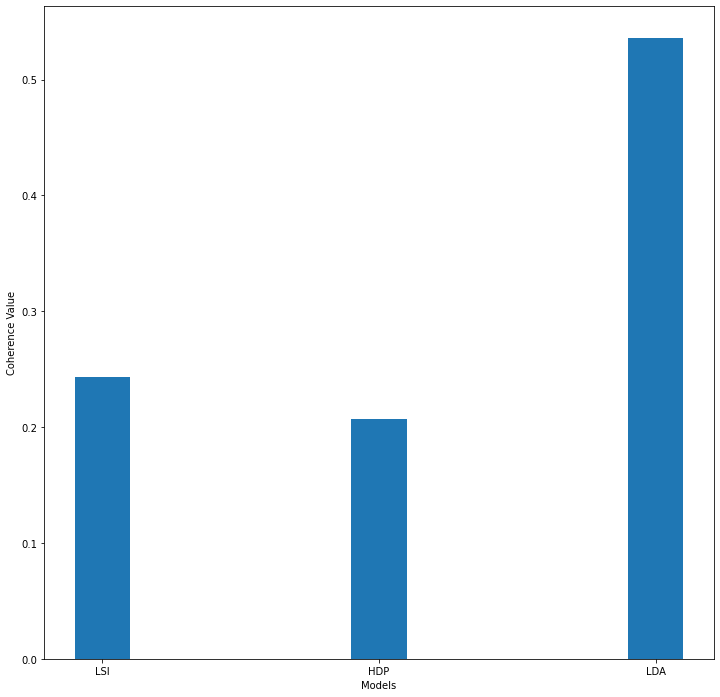

In [15]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

Sentiment models evaluation

In [16]:
import os, random

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

## Set fixed ranom seeds to get reproducible results
seed_val = 0
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

In [17]:
#Testdataset 0= negative 2=positive and 4= positive
data=pd.read_csv('testset9.csv',index_col=0, header=0)
data.head()

,text,sentiment,Label
0,@VirginAmerica What @dhepburn said.,neutral,2.0
1,@VirginAmerica plus you've added commercials t...,positive,4.0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2.0
3,@VirginAmerica it's really aggressive to blast...,negative,0.0
4,@VirginAmerica and it's a really big bad thing...,negative,0.0


Logistic Regression

In [18]:
from sklearn.model_selection import train_test_split

X = list(data.text.values)
y = list(data.Label.values)
labels = ['Negative','Neutral','Positive']
X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer() 

cv.fit(X_train_str) 

CountVectorizer()

In [20]:
X_train = cv.transform(X_train_str)
X_test = cv.transform(X_test_str)

In [21]:
print(X_train.toarray()[0])

[0 0 0 ... 0 0 0]


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer() 

tfidf.fit(X_train_str) # create the vocabulary

X_train_idf = tfidf.transform(X_train_str)
X_test_idf = tfidf.transform(X_test_str)

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='sag')
lr.fit(X_train, y_train)

C:\Users\Wehel\anaconda 3+\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(solver='sag')

In [24]:
from sklearn.metrics import classification_report

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, 
                          target_names=labels))

              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1826
     Neutral       0.64      0.61      0.62       611
    Positive       0.76      0.69      0.73       491

    accuracy                           0.80      2928
   macro avg       0.75      0.73      0.74      2928
weighted avg       0.80      0.80      0.80      2928



In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1635  142   49]
 [ 182  373   56]
 [  81   70  340]]


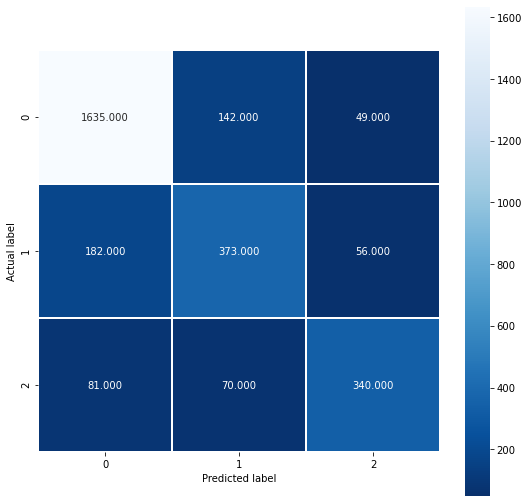

In [27]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
#plt.title(all_sample_title, size = 15);

 Text blob :Naive bayes classifier

In [28]:
data.head()

,text,sentiment,Label
0,@VirginAmerica What @dhepburn said.,neutral,2.0
1,@VirginAmerica plus you've added commercials t...,positive,4.0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2.0
3,@VirginAmerica it's really aggressive to blast...,negative,0.0
4,@VirginAmerica and it's a really big bad thing...,negative,0.0


In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize

def get_polarity(text):
    return TextBlob(text).sentiment.polarity
data['polarity'] = data['text'].apply(get_polarity)


In [30]:
data['sentiment1']=''
data.loc[data.polarity>0,'sentiment1']='positive'
data.loc[data.polarity==0,'sentiment1']='neutral'
data.loc[data.polarity<0,'sentiment1']='negative'
data.head()

,text,sentiment,Label,polarity,sentiment1
0,@VirginAmerica What @dhepburn said.,neutral,2.0,0.000000,neutral
1,@VirginAmerica plus you've added commercials t...,positive,4.0,0.000000,neutral
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2.0,-0.390625,negative
3,@VirginAmerica it's really aggressive to blast...,negative,0.0,0.006250,positive
4,@VirginAmerica and it's a really big bad thing...,negative,0.0,-0.350000,negative


In [31]:
X=np.zeros(len(data.sentiment1))
Y=data.sentiment1
for i in range(len(data.sentiment1)):
    
    if Y[i] =='negative':
        X[i]=0
    elif Y[i] == 'neutral':
        X[i]=2
    elif Y[i] == 'positive':
        X[i]=4
    
    
print(X)

[2. 2. 0. ... 2. 0. 4.]


In [32]:
data['Label1']=X
data.head()


,text,sentiment,Label,polarity,sentiment1,Label1
0,@VirginAmerica What @dhepburn said.,neutral,2.0,0.000000,neutral,2.0
1,@VirginAmerica plus you've added commercials t...,positive,4.0,0.000000,neutral,2.0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2.0,-0.390625,negative,0.0
3,@VirginAmerica it's really aggressive to blast...,negative,0.0,0.006250,positive,4.0
4,@VirginAmerica and it's a really big bad thing...,negative,0.0,-0.350000,negative,0.0


In [33]:
print(classification_report(data.Label,data.Label1, 
                          target_names=labels))

              precision    recall  f1-score   support

    Negative       0.88      0.35      0.50      9178
     Neutral       0.32      0.57      0.41      3099
    Positive       0.33      0.76      0.46      2363

    accuracy                           0.46     14640
   macro avg       0.51      0.56      0.46     14640
weighted avg       0.67      0.46      0.48     14640



In [34]:
cm1 = metrics.confusion_matrix(data.Label[0:2928], data.Label1[0:2928])
print(cm1)

[[705 637 557]
 [ 68 340 177]
 [ 19  89 336]]


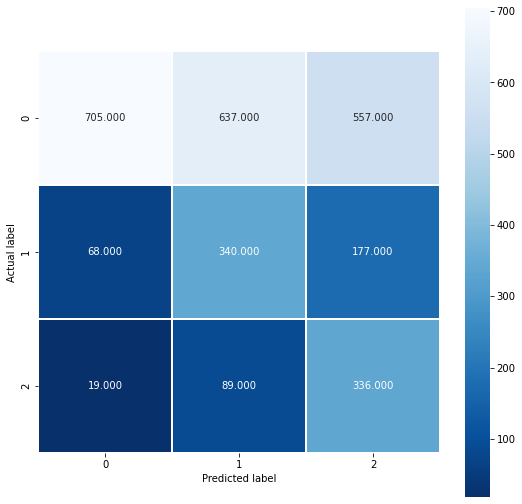

In [35]:
plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
#plt.title(all_sample_title, size = 15);

Decision trees:

In [36]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus

In [37]:
#lb = LabelEncoder() 
#data['text'] = lb.fit_transform(data['text'] ) 
#data['Label'] = lb.fit_transform(data['Label'])

In [38]:
# Split features and target variable
#X = data[['text']] 
#Y = data['Label']
# Instantiate a one hot encoder
#enc = OneHotEncoder()

# Fit the feature set X
#enc.fit(X)

# Transform X to onehot array 
#onehotX = enc.transform(X).toarray()

#onehotX, onehotX.shape, X.shape

In [39]:
#X_train, X_test , y_train,y_test = train_test_split(onehotX, Y, test_size = 0.3, random_state = 42) 

In [40]:
#clf= DecisionTreeClassifier(criterion='entropy')
#clf.fit(X_train,y_train) 
#y_pred = clf.predict(X_test)

In [41]:
#print(classification_report(y_test, y_pred, 
                          #target_names=labels))

In [42]:


X = list(data.text.values)
y = list(data.Label.values)
labels = ['Negative','Neutral','Positive']

In [43]:
X_train_st, X_test_st, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer() 

cv.fit(X_train_st) 

CountVectorizer()

In [45]:
X_train = cv.transform(X_train_st)
X_test = cv.transform(X_test_st)

In [46]:
# Create Decision Tree classifer object

#clf=tree.DecisionTreeClassifier()
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred1 = clf.predict(X_test)

In [47]:
print(classification_report(y_test, y_pred1, 
                          target_names=labels))

              precision    recall  f1-score   support

    Negative       0.78      0.81      0.79      1826
     Neutral       0.45      0.45      0.45       611
    Positive       0.60      0.53      0.56       491

    accuracy                           0.69      2928
   macro avg       0.61      0.59      0.60      2928
weighted avg       0.68      0.69      0.68      2928



In [49]:
cm2 = metrics.confusion_matrix(y_test, y_pred1)
print(cm2)

[[1472  250  104]
 [ 270  274   67]
 [ 140   91  260]]


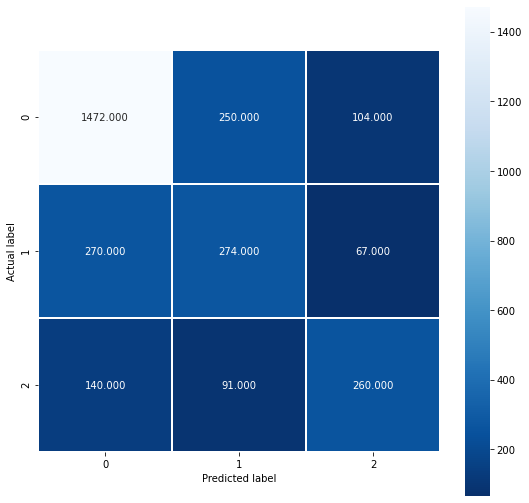

In [50]:
plt.figure(figsize=(9,9))
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy Score: {0}'.format(score)
#plt.title(all_sample_title, size = 15);

Text(0.5, 1.0, 'Accuracy of the models')

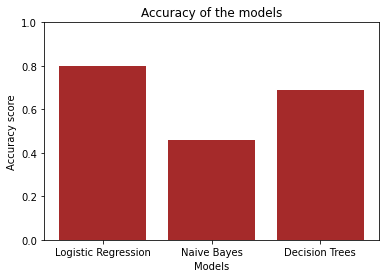

In [60]:
x=['Logistic Regression', 'Naive Bayes', 'Decision Trees']
y=[0.80,0.46,0.69]
plt.bar(x,y,color='brown')
plt.ylim(0,1)
plt.xlabel('Models')
plt.ylabel('Accuracy score')
plt.title('Accuracy of the models')